<a href="https://colab.research.google.com/github/gauthamhere/3.0P2/blob/master/GauthamK_Batch2_CIFAR10_ResNet18_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing dependencies , downloading the dataset and preprocessing the data

In [0]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from keras import layers
from keras import models
from keras.layers import Dense, Activation, Flatten, Dropout,GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import optimizers
import keras.backend as K
import cv2

%matplotlib inline

Using TensorFlow backend.


In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [0]:
num_classes=10

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices. One-Hot encoding
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Visualizing some of the images

In [0]:
def draw_img(i):
    im = x_train[i]
    c = y_train[i]
    mx=np.argmax(y_train[i])
    plt.imshow(im)
    plt.title(class_name[mx])
    plt.axis('off')

def draw_sample(X, y, n, rows=4, cols=4, fontsize=12):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = X[n+i].reshape(32,32,3)
        mx=np.argmax(y_train[i])
        plt.imshow(im, cmap='gnuplot2')
        plt.title(class_name[mx],fontsize=fontsize)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.6, hspace=0.01)
        plt.subplots_adjust(hspace=0.45, wspace=0.45)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

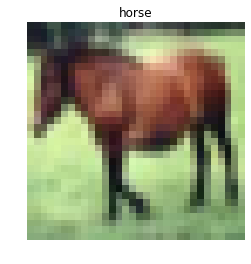

In [0]:
draw_img(7)

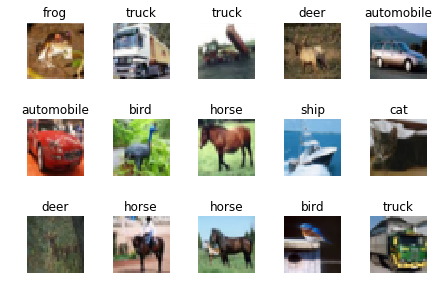

In [0]:
draw_sample(x_train, y_train, 0, 3, 5)

## Model building and training(transfer learning - ResNet18 with imagenet weights)

In [0]:
!pip install image-classifiers

     |████████████████████████████████| 81kB 3.8MB/s 


In [0]:
from classification_models.resnet import ResNet18, preprocess_input

base_model = ResNet18((32, 32, 3), weights='imagenet',include_top=False)

W0703 22:22:49.061101 139635945121664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 22:22:49.116936 139635945121664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 22:22:49.117778 139635945121664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0703 22:22:49.122691 139635945121664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0703 22:22:49.125423 139635

44924928/44920640 [==============================] - 1s 0us/step


In [0]:
def build_finetune_model(base_model, num_classes):
    for layer in base_model.layers:
        layer.trainable = True
        
    x = base_model.output

    x = GlobalAveragePooling2D(name='pool1')(x)
 
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [0]:
finetune_model = build_finetune_model(base_model, num_classes=num_classes)

In [0]:
finetune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [0]:
opt = optimizers.rmsprop(lr=0.0001, decay=1e-6)

finetune_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

W0703 22:22:55.577650 139635945121664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
batch_size = 100
epochs=8          

finetune_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

W0703 22:22:55.700793 139635945121664 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/8
50000/50000 [==============================] - 26s 528us/step - loss: 1.0640 - acc: 0.6361 - val_loss: 0.7802 - val_acc: 0.7378
Epoch 2/8
50000/50000 [==============================] - 20s 406us/step - loss: 0.5711 - acc: 0.8023 - val_loss: 0.6379 - val_acc: 0.7836
Epoch 3/8
50000/50000 [==============================] - 20s 406us/step - loss: 0.3688 - acc: 0.8727 - val_loss: 0.6641 - val_acc: 0.7903
Epoch 4/8
50000/50000 [==============================] - 20s 407us/step - loss: 0.2264 - acc: 0.9224 - val_loss: 0.7447 - val_acc: 0.7910
Epoch 5/8
50000/50000 [==============================] - 20s 402us/step - loss: 0.1423 - acc: 0.9529 - val_loss: 0.8159 - val_acc: 0.7979
Epoch 6/8
50000/50000 [==============================] - 20s 402us/step - loss: 0.0914 - acc: 0.9701 - val_loss: 0.8964 - val_acc: 0.7960
Epoch 7/8
50000/50000 [==============================] - 20s 402us/step - loss: 0.0699 - acc: 0.9772 - val_loss: 0.9591 - 

In [0]:
actual = np.argmax(y_test, axis=1)
prediction=[]
accuracy=[]
pred_arr=[]
incorrect_pred = []
correct_pred = []

for idx, val in enumerate(x_test):
  val = np.expand_dims(val, axis=0)
  pred = finetune_model.predict(val)
  pred_arr.append(pred)
  predicted_value = np.argmax(pred, axis=1)
  prediction.append(predicted_value)
  accuracy.append(np.amax(pred, axis=1)*100)
  if actual[idx] != predicted_value:
      incorrect_pred.append(idx)
  else:
      correct_pred.append(idx)

In [0]:
print("Number of incorrect predictions:",len(incorrect_pred))

Number of incorrect predictions: 2021


In [0]:
def draw_incorrect(X, y, n, rows=4, cols=4, fontsize=9):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = X[y[i]].reshape(32,32,3)
        plt.imshow(im, cmap='gnuplot2')
        
        
        
        plt.title("actual: %s\npredicted: %s" % (class_name[np.argmax(y_test[y[i]])], class_name[np.argmax(pred_arr[n+i])]), fontsize=fontsize, loc='left')
        plt.axis('off') 
        plt.subplots_adjust(top=6, bottom=3.9)
        plt.subplots_adjust(left=4, right=6)

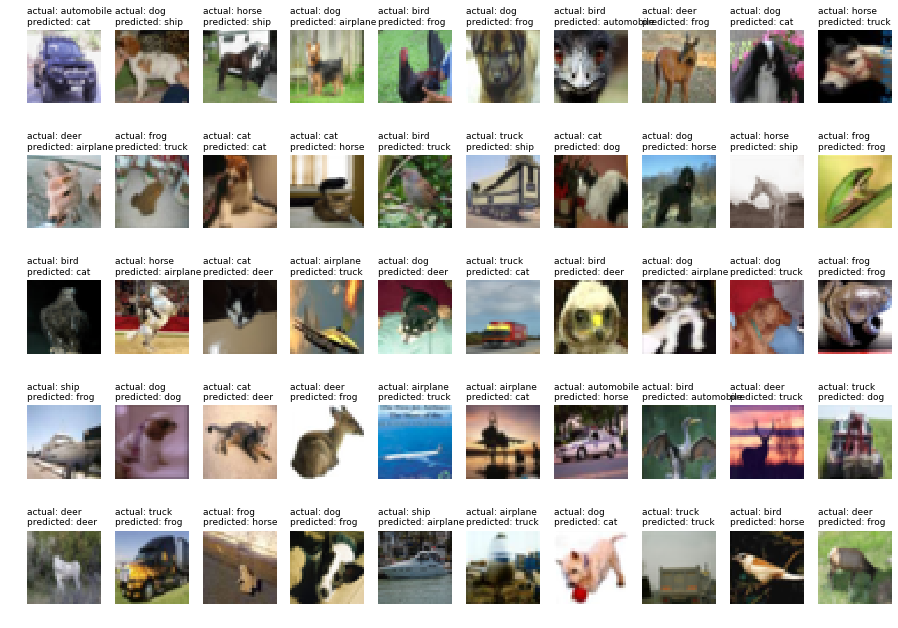

In [0]:
draw_incorrect(x_test,incorrect_pred,0,5,10)

# Grad-CAM

In [0]:
preds = finetune_model.predict(x_test[incorrect_pred])


def draw_gradcam(X, y, n, rows=4, cols=4, fontsize=9):
    for j in range(0, rows*cols):
        plt.subplot(rows, cols, j+1)
        class_idx = np.argmax(preds[j])
        class_output = finetune_model.output[:, class_idx]
        last_conv_layer = finetune_model.get_layer("add_2")
        
        grads = K.gradients(class_output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([finetune_model .input], [pooled_grads, last_conv_layer.output[0]])

        pooled_grads_value, conv_layer_output_value = iterate([x_test[incorrect_pred]])

        for i in range(64):
          conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
          
        heatmap = np.mean(conv_layer_output_value, axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        
        img = x_test[incorrect_pred[j]]
        img = np.uint8(255 * img)
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
        cvtd_superimp_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
        
        
        
        plt.imshow(cvtd_superimp_img, cmap='gnuplot2')
        
        
        
        plt.title("actual: %s\npredicted: %s" % (class_name[np.argmax(y_test[y[j]])], class_name[np.argmax(pred_arr[n+j])]), fontsize=fontsize, loc='left')
        plt.axis('off') 
        plt.subplots_adjust(top=6, bottom=3.9)
        plt.subplots_adjust(left=4, right=6)

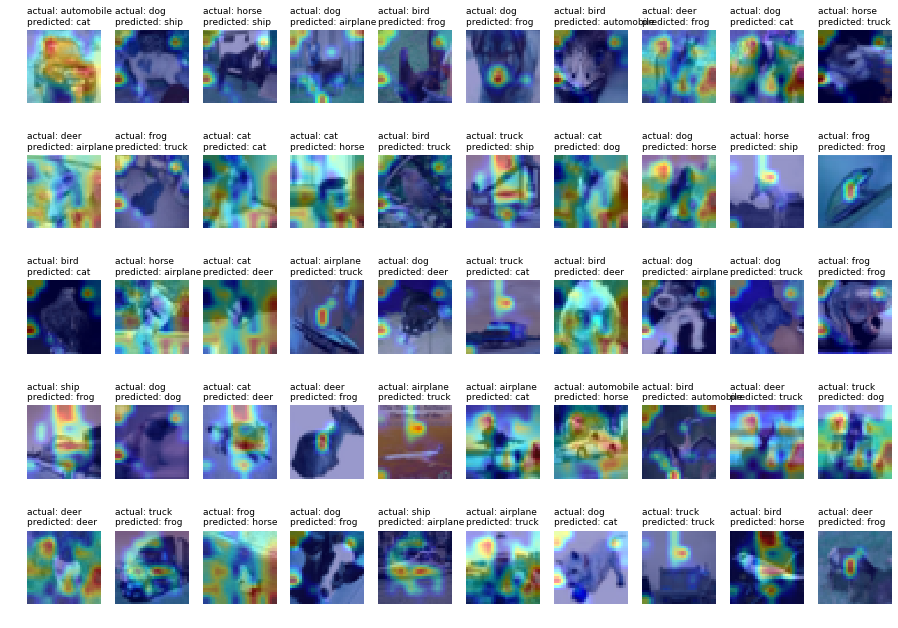

In [0]:
draw_gradcam(x_test,incorrect_pred,0,5,10)